In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Introdução ao Formato Raster e Processamento de Imagens com Rasterio

**Objetivos da aula**
* Entender o formato raster e sua importância para a análise geoespacial.
* Explorar a biblioteca Rasterio para trabalhar com imagens de satélite e outros dados raster.
* Realizar operações básicas de leitura, processamento e visualização de dados raster.

Os dados raster são comumente usados em imagens de satélite, modelos digitais de elevação (DEM), mapas de cobertura da terra e outros. Cada célula em um arquivo raster representa um valor em um determinado ponto geográfico.

# **Introdução ao Rasterio**

Rasterio é uma biblioteca Python que facilita a leitura e processamento de dados raster. Além disso, ela integra bem com outras bibliotecas geoespaciais como Geopandas e Shapely.

In [2]:
!pip install rasterio
import rasterio as rio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 44.2 MB/s eta 0:00:00


# **Trabalhando com dados raster no Rasterio**

Leitura de arquivos raster

In [3]:
path='/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/SF-23-X-D.tif'

with rio.open(path) as src:
    print(src.profile)  # Mostra as características do arquivo

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1800, 'height': 1200, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333535119891, 0.0, -43.50041578285163,
       0.0, -0.0008333333535119891, -21.000416255032178), 'blockxsize': 1800, 'blockysize': 2, 'tiled': False, 'interleave': 'band'}


Acessando metadados e propriedades

In [4]:
# Exibindo propriedades básicas
print(f'Número de bandas: {src.count}')
print(f'Altura, Largura: {src.height}, {src.width}')
print(f'Sistema de Coordenadas: {src.crs}')

Número de bandas: 1
Altura, Largura: 1200, 1800
Sistema de Coordenadas: EPSG:4326


Extração de bandas

In [5]:
# Carregar uma banda específica (por exemplo, a primeira banda)
with rio.open(path) as src:
    banda1 = src.read(1)  # Lendo a primeira banda

# Visualizando a matriz de valores da banda
print(banda1)

[[759 741 730 ... 229 251 263]
 [747 743 745 ... 262 283 292]
 [758 763 773 ... 281 299 316]
 ...
 [501 505 517 ... 536 542 530]
 [499 503 512 ... 532 528 524]
 [501 502 505 ... 533 534 559]]


**Visualização de dados raster**

In [6]:
import matplotlib.pyplot as plt

Visualização de uma banda

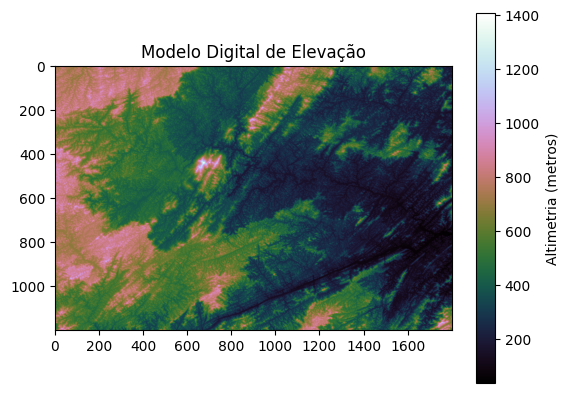

In [7]:
# Exibir uma única banda (grayscale)
plt.imshow(banda1, cmap='cubehelix')
plt.colorbar(label='Altimetria (metros)')
plt.title('Modelo Digital de Elevação')
plt.show()

**Composição RGB (imagens multibandas)**

Se o raster tiver várias bandas, como imagens de satélite, podemos compor uma imagem colorida.

Exemplo Landsat-8

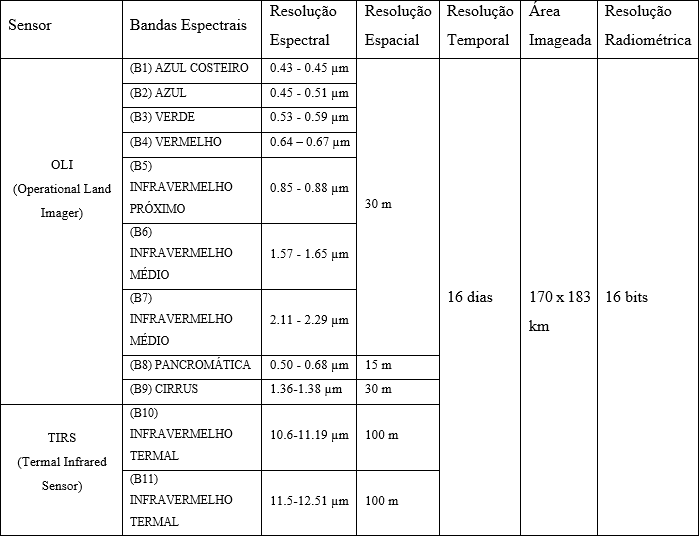

Fonte: https://earthexplorer.usgs.gov/

As imagens de cada banda espectral são baixadas individualmente. Vamos fazer o *layer stacking* (empilhamento de bandas) para deixá-las todas no mesmo arquivo.

Código para Layer Stacking

In [8]:
import numpy as np
import glob
import os

In [9]:
#Criar um novo diretório para salvar o arquivo com as imagens empilhadas
import os

if not os.path.exists('/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/SAIDA'):
  os.makedirs('/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/SAIDA')

from pathlib import Path
Path('./').mkdir(parents=True, exist_ok=True)

In [10]:
# Definir o diretório onde as bandas estão armazenadas
diretorio_bandas = '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/L8_2020075_20240821'

In [11]:
# Usar glob para buscar todas as bandas .TIF no diretório
banda_paths = sorted(glob.glob(os.path.join(diretorio_bandas, '*_SR_B*.TIF')))

In [37]:
banda_paths

['/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/L8_2020075_20240821/LC08_L2SP_220075_20240821_20240830_02_T1_SR_B1.TIF',
 '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/L8_2020075_20240821/LC08_L2SP_220075_20240821_20240830_02_T1_SR_B2.TIF',
 '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/L8_2020075_20240821/LC08_L2SP_220075_20240821_20240830_02_T1_SR_B3.TIF',
 '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/L8_2020075_20240821/LC08_L2SP_220075_20240821_20240830_02_T1_SR_B4.TIF',
 '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/L8_2020075_20240821/LC08_L2SP_220075_20240821_20240830_02_T1_SR_B5.TIF',
 '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/L8_2020075_20240821/LC08_L2SP_220075_20240821_20240830_02_T1_SR_B6.TIF',
 '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/L8_2020075_20240821/LC08_L2SP_220075_20240821_20240830_02_T1_SR_B7.TIF']

In [12]:
# Abrir a primeira banda para obter o profile e usar como base
with rio.open(banda_paths[0]) as src0:
    profile = src0.profile
    # Definir o número de bandas como o número de arquivos encontrados
    profile.update(count=len(banda_paths))

In [13]:
# Criar um array vazio para armazenar todas as bandas
stacked_array = []

In [14]:
# Abrir cada banda e adicionar ao array
for i, banda_path in enumerate(banda_paths):
    with rio.open(banda_path) as src:
        banda = src.read(1)  # Ler a banda
        stacked_array.append(banda)  # Adicionar a banda ao array

In [15]:
# Converter a lista em um array 3D
stacked_array = np.stack(stacked_array)

In [16]:
# Salvar o raster empilhado com todas as bandas
output_path = '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/SAIDA/L8_2020075_20240821_B1234567.tif'
with rio.open(output_path, 'w', **profile) as dst:
    for i in range(stacked_array.shape[0]):
        dst.write(stacked_array[i], i + 1)  # Escrever cada banda no novo arquivo

In [17]:
# Caminho para o arquivo empilhado
stacked_path = '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/SAIDA/L8_2020075_20240821_B1234567.tif'

In [18]:
# Abrir o arquivo empilhado
with rio.open(stacked_path) as src:
    # Ler as bandas desejadas para a composição (exemplo: 4, 3, 2 -> RGB)
    red = src.read(4)   # Banda 4 (Vermelho)
    green = src.read(3) # Banda 3 (Verde)
    blue = src.read(2)  # Banda 2 (Azul)

In [19]:
# Empilhar as bandas em um array 3D para a visualização RGB
rgb = np.dstack((red, green, blue))


A normalização dos valores para plotagem é uma etapa opcional, mas útil, quando os valores das bandas de uma imagem têm uma grande faixa de intensidades, geralmente acima de 1 (por exemplo, 0 a 65535 em imagens Landsat).

O matplotlib, utilizado para exibir imagens, trabalha melhor com valores no intervalo de 0 a 1, que correspondem à escala de intensidade de cor que vai do preto (0) ao branco (1).

Para fazer isso, cada pixel da imagem é dividido pelo valor máximo presente nas bandas, garantindo que os valores fiquem dentro de um intervalo adequado para visualização, mantendo as proporções relativas das intensidades de cor.

Essa normalização melhora a exibição visual sem alterar a essência dos dados subjacentes.

In [20]:
# Normalizar os valores para plotagem (opcional, depende dos dados)
rgb = rgb / np.max(rgb)

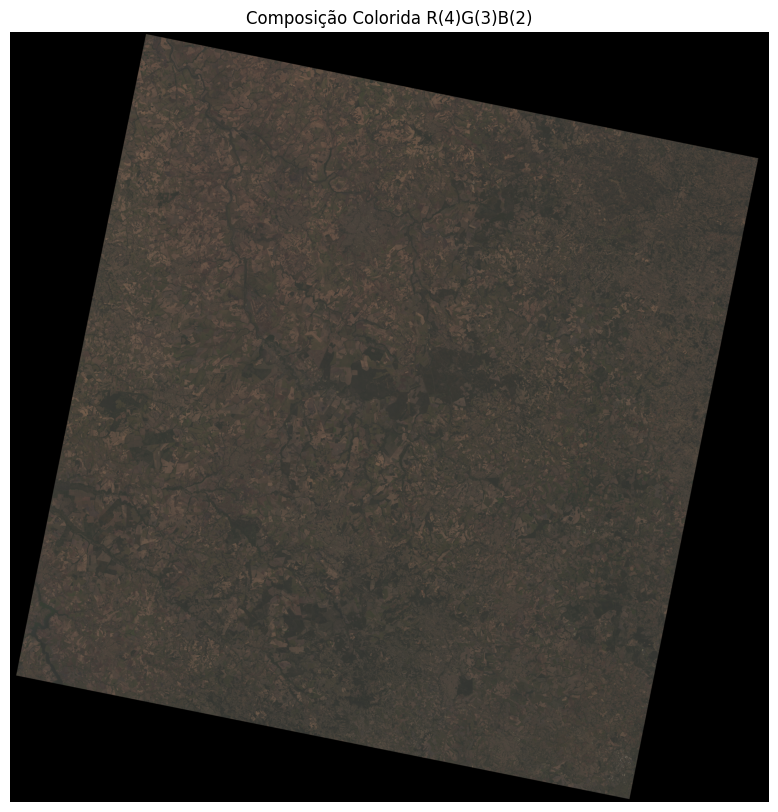

In [21]:
# Exibir a imagem RGB
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('Composição Colorida R(4)G(3)B(2)')
plt.axis('off')
plt.show()

 É possível melhorar o brilho e o contraste da imagem ajustando os valores dos pixels de maneira controlada. Uma técnica comum é o*stretching*  (alongamento) dos valores de pixel, como o *percentile stretch*, que corta os valores extremos das bandas (os pixels muito escuros e muito claros) para aumentar o contraste da imagem.

 Outra abordagem é aplicar uma transformação linear nos valores, como multiplicar os valores normalizados por um fator de brilho.

In [22]:
# Função para aplicar Percentile Stretch
def normalize_image(image, lower_percentile=2, upper_percentile=98):
    """ Normaliza a imagem utilizando um stretch percentual.
    Corta os extremos com base nos percentuais definidos para melhorar o contraste."""
    # Calcular os percentis inferior e superior
    min_val = np.percentile(image, lower_percentile)
    max_val = np.percentile(image, upper_percentile)

    # Aplicar a normalização com o stretch percentual
    stretched_image = np.clip((image - min_val) / (max_val - min_val), 0, 1)

    return stretched_image


No código, usamos os percentis 2 e 98 como valores padrão, significando que os 2% dos pixels mais escuros e mais claros serão cortados.

A função normalize_image() aplica o stretching com base nos percentis. Isso melhora o contraste, ajustando os valores dos pixels para o intervalo entre 0 e 1, mas excluindo os valores extremos que podem estar reduzindo o brilho da imagem.


In [23]:
# Aplicar a normalização para melhorar o brilho e contraste
red_stretched = normalize_image(red)
green_stretched = normalize_image(green)
blue_stretched = normalize_image(blue)

In [24]:
# Empilhar as bandas normalizadas em um array 3D para a visualização RGB
rgb_stretched = np.dstack((red_stretched, green_stretched, blue_stretched))

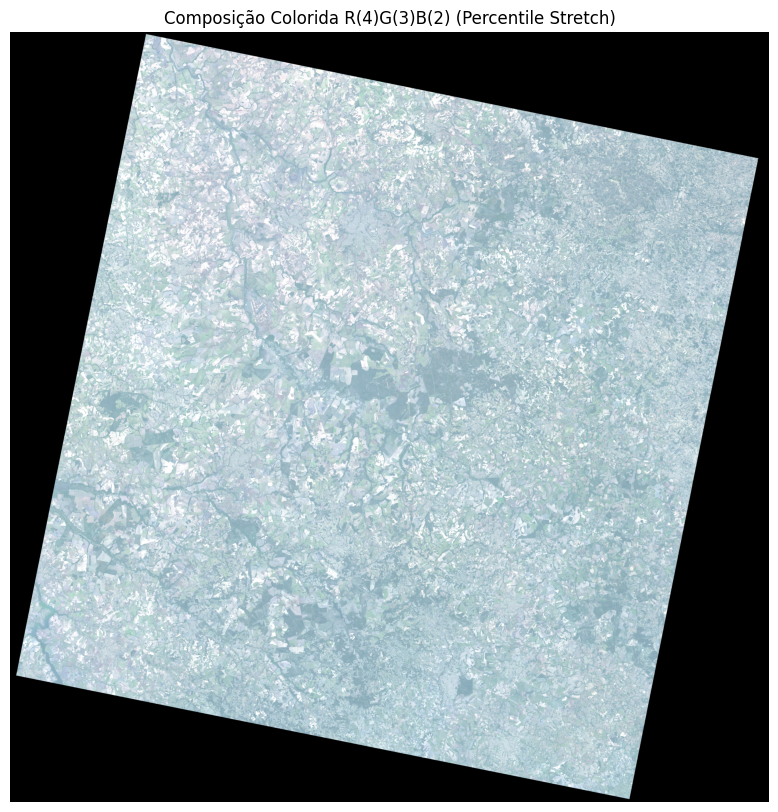

In [25]:
# Exibir a imagem RGB melhorada
plt.figure(figsize=(10, 10))
plt.imshow(rgb_stretched)
plt.title('Composição Colorida R(4)G(3)B(2) (Percentile Stretch)')
plt.axis('off')
plt.show()

# **Reamostragem e reprojeção**

In [26]:
# Reprojetando para um novo sistema de coordenadas
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [27]:
# Definindo o novo CRS
new_crs = 'EPSG:4674'  # SIRGAS 2000

In [28]:
# Calculando a nova transformação
transform, width, height = calculate_default_transform(
    src.crs, new_crs, src.width, src.height, *src.bounds)

In [29]:
# Caminho para o arquivo empilhado original
input_path = '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/SAIDA/L8_2020075_20240821_B1234567.tif'

In [30]:
path_reprojecao = '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/SAIDA/L8_2020075_20240821_B1234567_SIRGAS2000.tif'

# Abrir o arquivo de origem e realizar a reprojeção
with rio.open(input_path) as src:
    # Obter o transform e dimensões da imagem original
    transform, width, height = rio.warp.calculate_default_transform(
        src.crs, new_crs, src.width, src.height, *src.bounds)

    # Abrir o arquivo de saída para gravar o resultado reprojetado
    with rio.open(path_reprojecao,
                  'w', driver='GTiff',
                  height=height, width=width, count=src.count, dtype=src.dtypes[0],
                  crs=new_crs, transform=transform) as dst:
        # Reprojetar todas as bandas
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=new_crs,
                resampling=Resampling.nearest)

**Máscara e recorte com shapefiles**

In [31]:
import geopandas as gpd
from rasterio.mask import mask

In [32]:
# Carregar um shapefile
shapefile = gpd.read_file('/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/saocarlos-sp/saocarlos-sp.shp')


In [52]:
shapefile.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [38]:
path_image = '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/SAIDA/L8_2020075_20240821_B1234567_SIRGAS2000.tif'

A função mask do rasterio precisa que as geometrias sejam passadas como uma lista de objetos geométricos (polígonos ou outras formas geométricas). No entanto, quando carregamos um shapefile com o geopandas, ele retorna as geometrias em uma coluna do GeoDataFrame.

In [39]:
# Converter a geometria do shapefile para o formato necessário
geometries = [geom for geom in shapefile.geometry]

In [41]:
# Abrir o arquivo raster
with rio.open(path_image) as src:
    # Aplicar a máscara de corte com base nas geometrias do shapefile
    out_image, out_transform = mask(src, geometries, crop=True)

    # Atualizar o perfil do novo arquivo recortado
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Salvar o resultado recortado em um novo arquivo
    output_path = '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/SAIDA/L8_2020075_20240821_B1234567_SIRGAS2000_sao-carlos.tif'
    with rio.open(output_path, 'w', **out_meta) as dest:
        dest.write(out_image)

Visualização da imagem recortada

In [44]:
# Caminho para a imagem recortada
cropped = '/content/drive/MyDrive/DADOS_GEOPYTHON/Aula05/SAIDA/L8_2020075_20240821_B1234567_SIRGAS2000_sao-carlos.tif'

* Selecionar as bandas: out_image[[3, 2, 1], :, :] seleciona as bandas 4, 3 e 2 (no caso de imagens Landsat, essas bandas correspondem a vermelho, verde e azul, respectivamente). O primeiro índice refere-se às bandas, e [:, :] mantém a altura e a largura originais.

out_image[[3, 2, 1], :, :] tem a forma (3, altura, largura).


* Reorganizar a ordem das dimensões: transpose(1, 2, 0) reordena as dimensões para que a primeira dimensão seja a altura, a segunda dimensão seja a largura, e a terceira dimensão seja as bandas (vermelho, verde, azul).

transpose(1, 2, 0) transforma a estrutura de (3, altura, largura) para (altura, largura, 3).

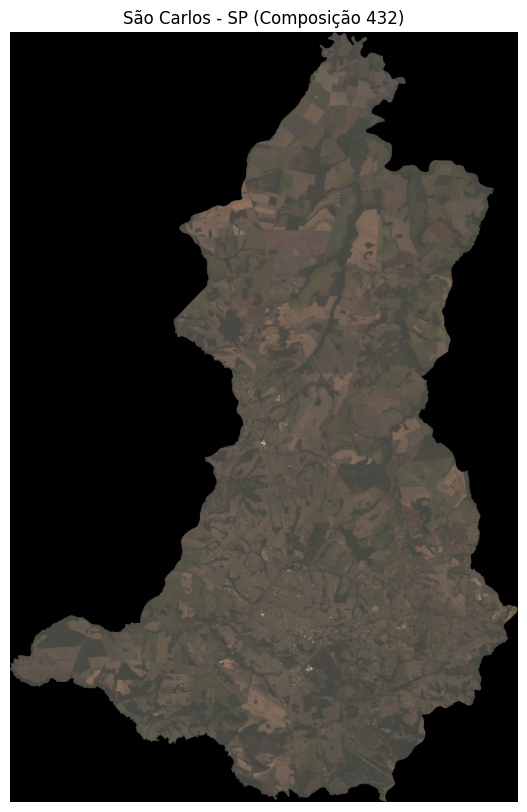

In [51]:
# Abrir a imagem recortada
with rio.open(cropped) as src:
    # Ler todas as bandas
    out_image = src.read()  # A forma será (bandas, altura, largura)

    # Reorganizar para (altura, largura, bandas)
    rgb_image = out_image[[3, 2, 1], :, :].transpose(1, 2, 0)  # (altura, largura, 3)

    # Normalizar os valores para plotagem (opcional, depende dos dados)
    rgb_image = rgb_image / np.max(rgb_image)

    # Configurar a figura para plotagem
    plt.figure(figsize=(10, 10))

    # Plotar a composição RGB
    plt.imshow(rgb_image)  # Banda 4 (Red), Banda 3 (Green), Banda 2 (Blue)

    # Adicionar título
    plt.title('São Carlos - SP (Composição 432)')

    # Remover os eixos
    plt.axis('off')


    # Exibir a imagem
    plt.show()